In [3]:
## Import neccesary libraries
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
from newsapi import NewsApiClient
import requests
from bs4 import BeautifulSoup
import re
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## 
import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.gensim_models as gensimvis
import pickle 


from wordcloud import WordCloud
from gensim import corpora
from gensim.models import LsiModel 
from gensim.models.ldamodel import LdaModel
from gensim.utils import simple_preprocess
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [4]:
newsapi = NewsApiClient(api_key='6c57d553c1f14d00971db51be4dd6a8d')
all_articles = newsapi.get_everything(q='vaccine',
                                      sources='bbc-news, cnn-news',
                                      domains='bbc.co.uk, edition.cnn.com',
                                      from_param='2021-05-01',
                                      to='2021-05-05',
                                      language='en',
                                      sort_by='relevancy',
                                      page=3)


In [12]:
## soup.find_all("p")

In [5]:
all_articles

{'status': 'ok',
 'totalResults': 46,
 'articles': [{'source': {'id': 'bbc-news', 'name': 'BBC News'},
   'author': 'https://www.facebook.com/bbcnews',
   'title': "Blossoms singer Tom Ogden: The joy of headlining the UK's first post-lockdown gig",
   'description': 'Stockport band Blossoms will perform for 5,000 people on Sunday, with no masks or social distancing.',
   'url': 'https://www.bbc.co.uk/news/newsbeat-56944509',
   'urlToImage': 'https://ichef.bbci.co.uk/news/1024/branded_news/E9A0/production/_118280895_tomindex.jpg',
   'publishedAt': '2021-05-01T23:50:58Z',
   'content': 'By Tracy Ollerenshaw &amp; Steve HoldenBBC Newsbeat\r\nimage copyrightGetty Images\r\nimage captionBlossoms lead singer Tom Ogden "can\'t wait" to see the crowd at Sefton Park on Sunday\r\n"I can\'t actually… [+3181 chars]'},
  {'source': {'id': 'bbc-news', 'name': 'BBC News'},
   'author': 'https://www.facebook.com/bbcnews',
   'title': 'Scottish election 2021: Scottish Labour pledge catch-up tutoring'

In [6]:
all_articles["articles"][-1]

{'source': {'id': 'bbc-news', 'name': 'BBC News'},
 'author': 'https://www.facebook.com/bbcnews',
 'title': 'Simon Stevens: How heavy hitter changed the NHS',
 'description': "Sir Simon Stevens has been called the NHS's most significant figure since its founder Aneurin Bevan.",
 'url': 'https://www.bbc.co.uk/news/health-56945830',
 'urlToImage': 'https://ichef.bbci.co.uk/news/1024/branded_news/8809/production/_118252843_mediaitem75190594.jpg',
 'publishedAt': '2021-05-03T23:37:35Z',
 'content': 'By Hugh PymHealth editor\r\nimage captionSir Simon Stevens stayed in the job to oversee the NHS rollout of Covid vaccinations\r\nThink like a patient, act like a taxpayer. That was the mantra of the head… [+6792 chars]'}

In [17]:
my_articles = {"Articles":[], "Source":[], "Published Date":[], "Url":[]}

In [18]:
# Unifying the paragraphs

articles = all_articles["articles"][:20]
for i in tqdm(range(len(articles)), ):
    url = articles[i]["url"]
    num_char = int(re.findall("[0-9]+", articles[i]["content"][-13:])[0])
    html_text = requests.get(url).text
    soup = BeautifulSoup(html_text, 'html5lib')
    x = soup.find_all("p")
    
    news_contents = []
    list_paragraphs = []
    phrase = []

    
    for p in np.arange(0, len(x)):
        paragraph = x[p].get_text()
        if p == 0:
            phrase.append(paragraph)
        else:
            phrase[0] += paragraph
        list_paragraphs.append(paragraph)
        cur_char = pd.Series(list(phrase[0])).value_counts().sum()
        final_article = " ".join(list_paragraphs)
        if cur_char >= num_char:
            break
    
    
    news_contents.append(final_article)
    my_articles["Articles"].append(final_article)
    my_articles["Source"].append(articles[i]["source"]["name"])
    my_articles["Published Date"].append(articles[i]["publishedAt"])
    my_articles["Url"].append(url)

  0%|          | 0/6 [00:00<?, ?it/s]

In [19]:
df = pd.DataFrame(my_articles)
df.head()

,Articles,Source,Published Date,Url
0,By Tracy Ollerenshaw & Steve HoldenBBC Newsbea...,BBC News,2021-05-01T23:50:58Z,https://www.bbc.co.uk/news/newsbeat-56944509
1,Scottish Labour has pledged to offer catch-up ...,BBC News,2021-05-03T12:56:17Z,https://www.bbc.co.uk/news/uk-scotland-scotlan...
2,Scotland's politicians have launched their fin...,BBC News,2021-05-05T12:53:27Z,https://www.bbc.co.uk/news/uk-scotland-scotlan...
3,By Francesca GillettBBC News Prime Minister Bo...,BBC News,2021-05-03T11:44:38Z,https://www.bbc.co.uk/news/uk-56970260
4,Some Bradford schools are missing pupils becau...,BBC News,2021-05-05T23:55:20Z,https://www.bbc.co.uk/news/health-56873813


In [92]:
news_contents[:num_char]

['Some Bradford schools are missing pupils because they travelled abroad with their families, who cannot now get back without paying a hefty bill for hotel quarantine. This is just one of the risks of travel during a global pandemic, says Dr John Wright of Bradford Royal Infirmary, who notes that British travellers may also have contributed to the spread of the virus. A head teacher tells me that she has a problem with families stuck abroad, in countries on the UK\'s red list.  British residents who have been in one of these countries have to spend 10 days in quarantine in a hotel when they arrive back, at a cost of Â£1,750 for a single adult, and much more for families. Those who can\'t afford it are sometimes staying where they are - perhaps living free of charge with relatives - and this has left noticeable gaps in some classes. In Bradford, families are mostly stuck in Pakistan, where the majority of the city\'s Asian population originates, but it\'s clear that many UK families are

In [20]:
## Saving the article list as a csv file

df.to_csv("Article1.csv", index=False)

In [21]:
## Reading the saved file in
data = pd.read_csv("Article1.csv")
data.head()

,Articles,Source,Published Date,Url
0,By Tracy Ollerenshaw & Steve HoldenBBC Newsbea...,BBC News,2021-05-01T23:50:58Z,https://www.bbc.co.uk/news/newsbeat-56944509
1,Scottish Labour has pledged to offer catch-up ...,BBC News,2021-05-03T12:56:17Z,https://www.bbc.co.uk/news/uk-scotland-scotlan...
2,Scotland's politicians have launched their fin...,BBC News,2021-05-05T12:53:27Z,https://www.bbc.co.uk/news/uk-scotland-scotlan...
3,By Francesca GillettBBC News Prime Minister Bo...,BBC News,2021-05-03T11:44:38Z,https://www.bbc.co.uk/news/uk-56970260
4,Some Bradford schools are missing pupils becau...,BBC News,2021-05-05T23:55:20Z,https://www.bbc.co.uk/news/health-56873813


In [5]:
## removing punctuation marks

data["Articles"] = data["Articles"].apply(lambda x: re.sub(r'[^\w\s]', '', x))
data.head(2)

,Articles,Source,Chracter Length,Url
0,By Tracy Ollerenshaw Steve HoldenBBC Newsbeat...,BBC News,3181,https://www.bbc.co.uk/news/newsbeat-56944509
1,Scottish Labour has pledged to offer catchup t...,BBC News,5239,https://www.bbc.co.uk/news/uk-scotland-scotlan...


In [75]:
## get the number of words present in each article
data["Word Count"] = data["Articles"].apply(lambda x: len(x.split()))

In [79]:
data.head(2)

,Articles,Source,Chracter Length,Url,Word Count
0,By Tracy Ollerenshaw Steve HoldenBBC Newsbeat...,BBC News,3181,https://www.bbc.co.uk/news/newsbeat-56944509,584
1,Scottish Labour has pledged to offer catchup t...,BBC News,5239,https://www.bbc.co.uk/news/uk-scotland-scotlan...,899


<AxesSubplot:title={'center':'Word Count in Articles'}, xlabel='Word Count', ylabel='Count'>

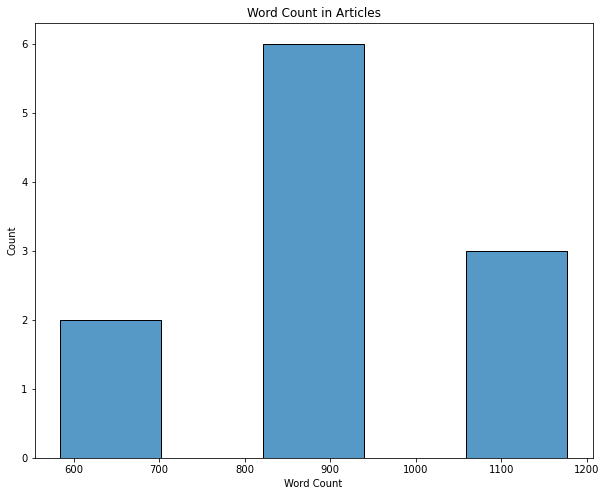

In [83]:
plt.figure(figsize=(10, 8))
plt.title("Word Count in Articles")
sns.histplot(x="Word Count", data=data)

In [6]:
data["Articles"][6]

'Scottish Labour has pledged to offer catchup tutoring to every pupil in Scotland Leader Anas Sarwar said educational standards had fallen under the SNP with promises of closing the attainment gap turning out to be empty He said his party would focus on improving education to avoid another lost generation of children Scottish Labours aim was to make Scotland a world leader in education again Mr Sarwar added The partys education plan includes giving free access to sport outdoor activities arts and culture to every young person over the summer Mr Sarwar said We need a Scottish Labour opposition at Holyrood standing up for the young people of Scotland and keeping the first ministers eye on the ball We cant afford to gamble with the futures of the children of Scotland On Thursday vote for a better future for our young people  use both your votes for Labour SCOTLAND ALERTS  Get extra updates on BBC election coverage Elsewhere on the campaign trail the Scottish Greens have prioritised a gree

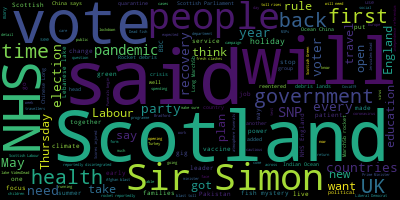

In [7]:
# Join the different processed titles together.
long_string = ','.join(list(data["Articles"].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="black", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## Latent Semantic Analysis

In [8]:
def preprocessesing(article_list):
    """
    """
    
    ## Initialize Regular experession tokenixer
    tokenizer = RegexpTokenizer(r'\w+')
    
    ##Create English stopeords
    stopword = stopwords.words("english")
    stopword.extend(['from', 'subject', 'said', 'edu', 'use'])
    
    ## Initilizing PorterStemmer
    p_stem = PorterStemmer()
    
    text = []
    
    ## loop through the articles
    for i in article_list:
        
        ## turn everythin to lower case
        low = i.lower()
        
        ## tokenize lower case
        tokens = tokenizer.tokenize(low)
        
        ## removing stopwords
        tokens = [i for i in tokens if i not in stopword]
        
        ## Stemming tokens
        stem = [p_stem.stem(i) for i in tokens]
        
        ## add to the empty text list
        text.append(stem)
        
    
    return text

In [9]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [10]:
def prepare_corpus(clean_text):
    """
    """
    
    dictionary = corpora.Dictionary(clean_text)
    
    doc_term_matrix = [dictionary.doc2bow(text) for text in clean_text]
    
    return dictionary, doc_term_matrix

In [20]:
def lsa_model(clean_text, num_topics, words):
    """
    """
    
    dictionary, doc_term_matrix = prepare_corpus(clean_text)
    
    lsamodel = LsiModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary)
    print(lsamodel.print_topics(num_topics=num_topics, num_words=words))
    return lsamodel, dictionary, doc_term_matrix
    

In [60]:
number_of_topics = 5
words = 10

clean_text = preprocessesing(data["Articles"])
model, dictionary, doc_term_matrix = lsa_model(clean_text=clean_text, num_topics=number_of_topics, words=words)

[(0, '0.337*"scotland" + 0.234*"vote" + 0.217*"scottish" + 0.194*"nh" + 0.173*"elect" + 0.172*"health" + 0.153*"snp" + 0.133*"leader" + 0.133*"recoveri" + 0.129*"sir"'), (1, '-0.394*"nh" + -0.298*"sir" + -0.296*"simon" + 0.243*"scotland" + -0.226*"health" + -0.190*"england" + 0.178*"vote" + 0.161*"scottish" + 0.130*"elect" + 0.115*"snp"'), (2, '0.311*"travel" + 0.255*"countri" + 0.243*"open" + 0.228*"holiday" + 0.178*"got" + 0.165*"uk" + -0.155*"nh" + 0.149*"rule" + 0.145*"expect" + -0.111*"simon"'), (3, '0.236*"say" + 0.201*"tom" + 0.201*"gig" + 0.199*"like" + 0.162*"live" + 0.161*"back" + -0.156*"open" + -0.139*"holiday" + 0.135*"pakistan" + -0.108*"got"'), (4, '0.235*"pakistan" + -0.188*"gig" + -0.188*"tom" + 0.180*"famili" + 0.174*"travel" + 0.164*"bradford" + -0.160*"like" + -0.126*"test" + 0.119*"uk" + 0.117*"india"')]


In [61]:
cm = CoherenceModel(model=model, texts=clean_text, coherence='u_mass', topn=10)
coherence = cm.get_coherence()  # get coherence value

In [62]:
coherence

-1.3833028347937089

## Latent Dirichlet Allocation

LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.

In [63]:
def lda_model(clean_text, num_topics, words):
    """
    """
    
    dictionary, doc_term_matrix = prepare_corpus(clean_text)
    lda_model = LdaModel(corpus=doc_term_matrix, id2word=dictionary, num_topics=num_topics,  passes=10)
    print(lda_model.print_topics(num_topics=num_topics, num_words=words))
    return lda_model

In [64]:
## LDA model
model = lda_model(clean_text=clean_text, num_topics=number_of_topics, words=words)

[(0, '0.013*"say" + 0.010*"like" + 0.009*"gig" + 0.009*"tom" + 0.009*"back" + 0.008*"live" + 0.007*"travel" + 0.007*"uk" + 0.007*"peopl" + 0.007*"pakistan"'), (1, '0.001*"scotland" + 0.001*"scottish" + 0.001*"vote" + 0.001*"elect" + 0.001*"say" + 0.001*"health" + 0.001*"recoveri" + 0.001*"countri" + 0.001*"back" + 0.001*"govern"'), (2, '0.027*"scotland" + 0.020*"vote" + 0.018*"scottish" + 0.015*"elect" + 0.013*"snp" + 0.011*"recoveri" + 0.010*"parti" + 0.009*"leader" + 0.009*"voter" + 0.009*"green"'), (3, '0.001*"nh" + 0.001*"health" + 0.001*"scotland" + 0.001*"sir" + 0.001*"say" + 0.001*"simon" + 0.001*"govern" + 0.001*"first" + 0.001*"peopl" + 0.001*"like"'), (4, '0.019*"nh" + 0.014*"sir" + 0.014*"health" + 0.013*"simon" + 0.011*"england" + 0.008*"open" + 0.008*"travel" + 0.008*"countri" + 0.008*"need" + 0.008*"holiday"')]


In [65]:
vis_data = gensimvis.prepare(model, doc_term_matrix, dictionary)
pyLDAvis.display(vis_data)